In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
%matplotlib inline

def pltDefaultPar():
    #reset default matplotlib parameters for this notebook
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8

rootTP="/home/johann/Remote/imac"
rootMAC="/Users/jh"
root=rootTP

In [8]:
def plotdataArr(dataArray,xlabel,lineArr,lineParam='',title='',linestyles='',setlog='',legendloc='upper center'):
    # color stuff: http://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    pltPrintPar()
    colors=cm.rainbow(np.linspace(0,1,len(dataArray)))
    if linestyles=='': lslist = len(dataArray) * ['o-']
    else: lslist = linestyles
    plt.figure(figsize=(7,5))
    for i, line in enumerate(dataArray):
        ti = lineParam + ' = ' + str(lineArr[i])
        xs = line[:,0]
        dd0s = line[:,1]/6.
        plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
    plt.xlabel(r'$'+xlabel+'$')
    plt.ylabel(r'$D/D_0$')
    plt.ylim([0,1.3])
    plt.title(title)
    plt.legend(loc=legendloc, bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
    if setlog=='y' or setlog=="double":
        plt.yscale('log')
    if setlog=='x' or setlog=="double":
        plt.xscale('log')
    plt.show()
        

# Compare D over p for ranRod and SPSnoHI

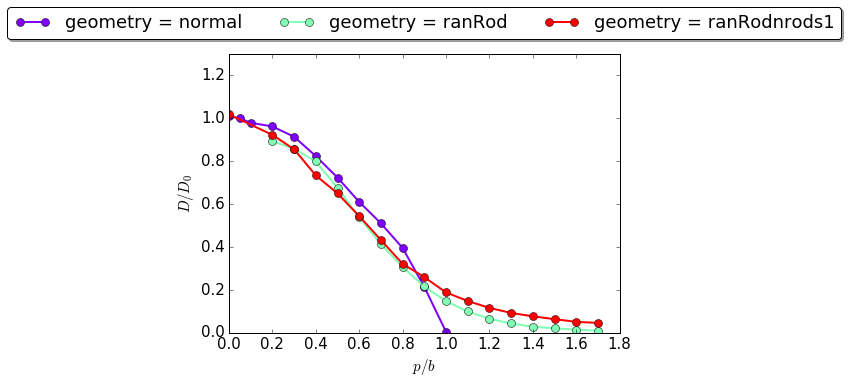

In [3]:
triggerArr = ['normal','ranRod','ranRod/nrods1']
triggerNameArr = []
U=0
a=0# This if fixed here, for no HI
datadir= root + "/Documents/workspace-cpp"
afrac = '%g'%(float(a)/10)
dataArr=[]
for trigger in triggerArr:
    if trigger == 'normal':
        typedir='/SingleParticleSimulation/sim_dataOLD/noreset/dt0.0001/t200/d0/b10/'
        MSD=''
    else:
        typedir='/SingleParticleSimulation/Release/sim_data/noreset/'+trigger+'/dt0.0005/t200/d0/b10'
        MSD='MSD'
    triggerNameArr.append(trigger.replace('/',''))
    folder=datadir + typedir
    data = []
    for pdir in os.listdir(folder):
        file=os.path.join(folder, pdir,'k1.000/u0/InstantValues/linear_fit_parameters'+str(MSD)+'.txt')
        if os.path.isfile(file):
            p=file.split('/p')[1].split('/k')[0] # assign value from dir to p
            p='%g'%(float(p)/10)                 # make p value p/b
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(p)+a/10.,float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
    dataArr.append(np.array(sorted(data)))
u0data = (dataArr)

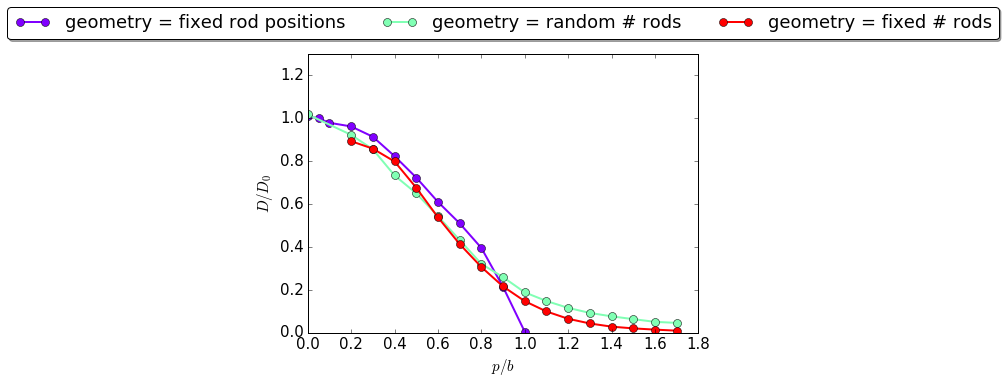

In [12]:
u0data[1],u0data[2] = u0data[2],u0data[1]
triggerNameArr = ['fixed rod positions', 'random # rods','fixed # rods']
plotdataArr(u0data,r'p/b',lineArr=triggerNameArr,lineParam='geometry')

### Functions for all heterogeneous hydrogel obstruction models

286.86755537231954


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in multiply


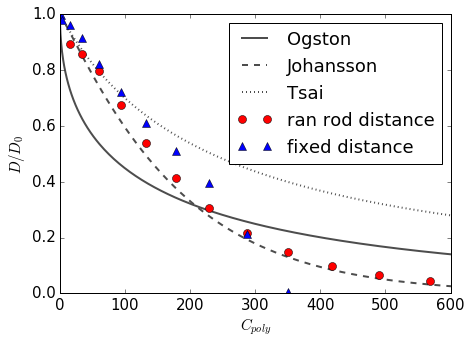

In [270]:
Vcyl = lambda a, b: np.pi*b*(a/2.)**2
def phi(a,b=10): return (3*Vcyl(a,b) - 8 * np.sqrt(2) * (a/2.)**3)/b**3
def alpha(p, a):
    return phi(a,b=1)*((a+p)/a)**2

def Ogston(p, a):
    return np.exp( -(a+p)/a * np.sqrt(phi(a,b=1)))

def Johansson(p, a):
    return np.exp(-0.84 * alpha( p, a)**1.09)

def Tsai(p, a):
    return (1 + 2/3 *alpha(p, a))**-1


# For Alexa in Dextran values in nanometers
m_a=162*1.66
aexp=0.39
pexp=1.9
aop = aexp/pexp

def Cpoly(a,aexp=0.4):
    "m_a is the monomer weight, a the monomer diameter in relative units"
    Vmonomer_exp = Vcyl(aexp,aexp)
    # nmonomerPerCell = Vpolymer/Vmonomer with phi = Vpolymer/Vcell
    return m_a * phi(a,b=1) / Vmonomer_exp
atest=0.05



def CpolyFromp(p_s):
    return (p_s**3 *m_a / (aexp*(pexp+aexp)**3)) * (3 * (pexp+aexp)/p_s - 2 * aexp)
print(CpolyFromp(0.9))#WORKS!

#Extract simulation data 
ranRodData = u0data[1]
psRR = ranRodData[:,0]
dd0sRR = ranRodData[:,1]/6.
SPSData = u0data[0]
psSPS = SPSData[:,0]
dd0sSPS = SPSData[:,1]/6.

avals = np.arange(0.0001,0.27,0.001)
Cvals = Cpoly(avals)

#Plot it all together
pltPrintPar()
plt.figure(figsize=(7,5))
colors=cm.rainbow(np.linspace(0,1,5))
lst=['-','--',':']
functions=[Ogston,Johansson,Tsai]
for i,f in enumerate(functions):
    #plt.plot(phivals, f(avals/aop , avals),label=f.__name__)
    dd0vals =  f(avals/aop , avals)
    plt.plot(Cvals,dd0vals,label=f.__name__,linestyle=lst[i],c='0.3' )
plt.plot(CpolyFromp(psRR),dd0sRR,'ro',label='ran rod distance')
plt.plot(CpolyFromp(psSPS),dd0sSPS,'b^',label='fixed distance')
plt.xlabel(r'$C_{poly}$')
#plt.xlabel(r'$\phi$')
plt.ylabel(r'$D/D_0$')
plt.xlim([0,600])
plt.legend()
plt.show()

[  0.09719065  11.40325853]


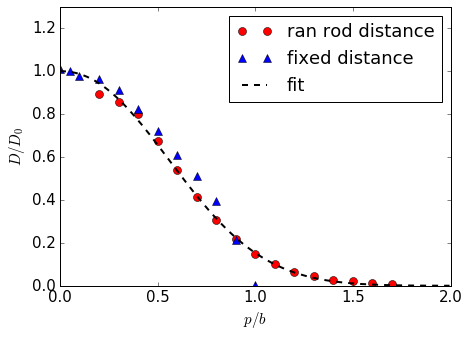

In [213]:
def sexp(x,a,n):
    return np.exp( - a * x ** n )

fit, pcov =curve_fit(sexp, psRR, dd0sRR)
print(fitI)
xs = np.arange(0,2,0.005)
ysI = sexp(xs, *fit)
pltPrintPar()
plt.figure(figsize=(7,5))
plt.plot(psRR,dd0sRR,'ro',label='ran rod distance')
plt.plot(psSPS,dd0sSPS,'b^',label='fixed distance')
plt.plot(xs,ysI,'k--',label='fit')
plt.xlabel(r'$p/b$')
plt.ylabel(r'$D/D_0$')
plt.ylim([0,1.3])
plt.legend()
plt.savefig('DoverpRanRodFit.png')
plt.show()
pltDefaultPar()

# Compare D over U_0 for ranRod

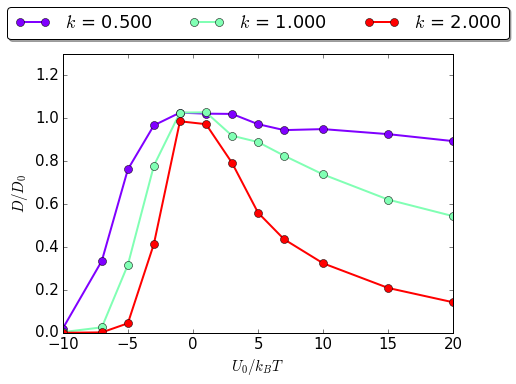

In [284]:
trigger ='ranRod'
triggerNameArr = []
p=0
ks=['0.500','1.000','2.000']
a=0# This if fixed here, for no HI
datadir= root + "/Documents/workspace-cpp/SingleParticleSimulation/Release/sim_data/noreset/"
dataArr=[]
for k in ks:
    MSD='MSD'
    triggerNameArr.append(trigger.replace('/',''))
    folder=datadir +trigger+'/dt0.0005/t200/d0/b10/p'+str(p)+'/k'+str(k)+'/'
    data = []
    for udir in os.listdir(folder):
        file=os.path.join(folder, udir,'InstantValues/linear_fit_parametersMSD.txt')
        if os.path.isfile(file):
            u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
    dataArr.append(np.array(sorted(data)))
ksdata = (dataArr)
plotdataArr(ksdata,r'U_0/k_B T',lineArr=ks,lineParam='$k$')

## Get noRan Data and compare

In [285]:
p=0
ks=['0.500','1.000','2.000']
a=0# This if fixed here, for no HI
datadir= root + "/Documents/workspace-cpp/SingleParticleSimulation/sim_dataOLD/noreset/"
dataArr=[]
for k in ks:
    MSD='MSD'
    triggerNameArr.append(trigger.replace('/',''))
    folder=datadir +'/dt0.0001/t200/d0/b10/p'+str(p)+'/k'+str(k)+'/'
    data = []
    for udir in os.listdir(folder):
        file=os.path.join(folder, udir,'InstantValues/linear_fit_parameters.txt')
        if os.path.isfile(file):
            u=file.split('/u')[1].split('/I')[0] # assign value from dir to 
            with open(file, 'r') as fitf:
                m = (fitf.readline().split('m')[1]).split()[0]
            data.append([float(u),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
    dataArr.append(np.array(sorted(data)))
ksdataOld = (dataArr)

6 6


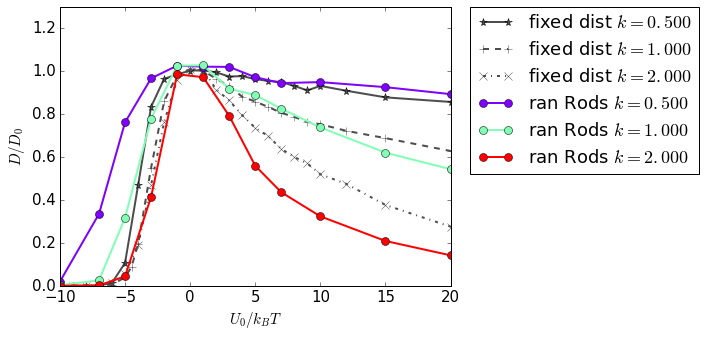

In [290]:
#plotdataArr(ksdata,,lineArr=ks,lineParam='$k$')

combinaksData =ksdata + ksdataOld
print(len(ksComb), len(combinaksData))
pltPrintPar()
colors=cm.rainbow(np.linspace(0,1,len(ksdata)))
plt.figure(figsize=(7,5))
lslist= ['*-','+--','x-.']
for i, line in enumerate(ksdataOld):
    ti = 'fixed dist $k = ' + str(ks[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c='0.3') # '0.75' is shade of grey
lslist=3 * ['o-'] 
for i, line in enumerate(ksdata):
    ti = 'ran Rods $k = ' + str(ks[i]) +'$'
    xs = line[:,0]
    dd0s = line[:,1]/6.
    plt.plot(xs,dd0s,lslist[i],label=ti,c=colors[i])
plt.xlabel(r'$U_0/k_B T$')
plt.ylabel(r'$D/D_0$')
plt.ylim([0,1.3])
plt.xlim([-10,20])
#plt.legend(loc=2, bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Pore size distributions
which pore size distributions do I pick up with my usual methods?

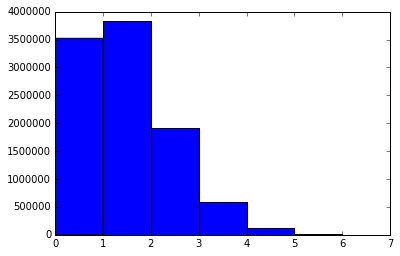

In [30]:
tries = 12
probrod = 1./tries
nrods = []
for k in range(10**7):
    count=0
    for i in range(tries):
        if (np.random.uniform() < probrod):
            count+=1
    nrods.append(count)
plt.hist(nrods,bins=[0, 1, 2, 3, 4, 5, 6, 7])
plt.show()
bs=[]
nzeros=0
for n in nrods:
    if n== 0: nzeros+=1
    elif nzeros!=0: 
        bs.append(nzeros)
        nzeros=0
    else: bs.append(1./n)

(array([  1.71142900e+06,   3.96327200e+06,   5.21319000e+05,
          1.82672000e+05,   0.00000000e+00,   6.47650000e+04,
          2.25900000e+04,   8.02700000e+03,   0.00000000e+00,
          2.85200000e+03,   1.06100000e+03,   3.42000000e+02,
          0.00000000e+00,   1.33000000e+02,   5.70000000e+01,
          1.40000000e+01,   0.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   1.00000000e+00]),
 array([  0.11111111,   0.85555556,   1.6       ,   2.34444444,
          3.08888889,   3.83333333,   4.57777778,   5.32222222,
          6.06666667,   6.81111111,   7.55555556,   8.3       ,
          9.04444444,   9.78888889,  10.53333333,  11.27777778,
         12.02222222,  12.76666667,  13.51111111,  14.25555556,  15.        ]),
 <a list of 20 Patch objects>)

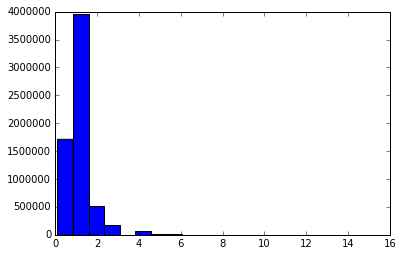

In [36]:
plt.hist(bs,bins=20)

## Can I manage to pick up the same distribution that I was sourcing from?
Use Poisson distribution
$$P(\beta) = \frac{\lambda^k \exp(-\lambda)}{\beta!}$$
this is np.random.poisson(lam=1.0, size=None)

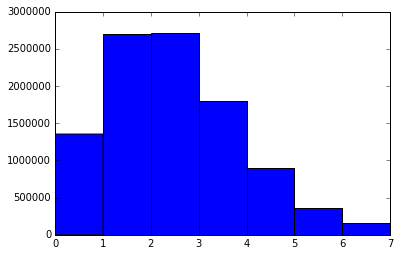

In [40]:
nrodsPoiss = [np.random.poisson(2) for x in range(10**7)]
plt.hist(nrodsPoiss,bins=[0, 1, 2, 3, 4, 5, 6, 7])
plt.show()
bsP=[]
nzeros=0
for n in nrodsPoiss:
    if n== 0: nzeros+=1
    elif nzeros!=0: 
        bsP.append(nzeros)
        nzeros=0
    else: bsP.append(1./n)

(array([  1.23453500e+06,   3.90284100e+06,   0.00000000e+00,
          3.35028200e+06,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.36575000e+05,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.86030000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.57700000e+03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.13000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.50000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   6.00000000e+00]),
 array([ 0.08333333,  0.31388889,  0.54444444,  0.775     ,  1.00555556,
         1.23611111,  1.46666667,  1.69722222,  1.92777778,  2.15833333,
         2.38888889,  2.61944444,  2.85      ,  3.08055556,  3.31111111,
         3.54166667,  3.77222222,  4.00277778,  4.23333333,  4.46388889,
         4.69444444,  4.925     ,  5.15555556,  5.38611111,  5.61666667,
         5.84

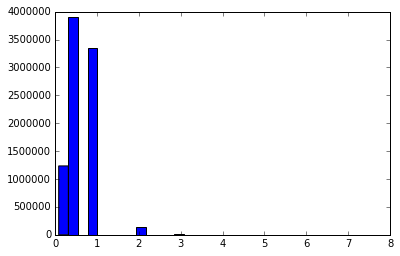

In [41]:
plt.hist(bsP,bins=30)

# Test position shifting of ranRods
data obtained by printRodVec() function output, copied from terminal

In [28]:
data = [
    [[0,1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,14.5519],[0,19.2135,16.2913],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,16.3634],[0,5.98765,19.7305],[0,14.3178,16.7654],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-7.06849],[0,19.2135,-3.31735],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-8.87373],[0,5.98765,-3.07538],[0,14.3178,-1.66017],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,17.8838],[0,19.2135,13.9608],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,12.5631],[0,5.98765,18.2601],[0,14.3178,18.8949],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-8.09765],[0,19.2135,-1.14375],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-4.28119],[0,5.98765,-4.71684],[0,14.3178,-0.0902639],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,16.6799],[0,19.2135,10.6748],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.734],[0,5.98765,17.0538],[0,14.3178,17.569],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-4.72065],[0,19.2135,-0.884411],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.87775],[0,5.98765,-2.11346],[0,14.3178,-2.76274],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[0,1] ,[0,17.5536,-4.72065],[0,19.2135,-0.884411],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.87775],[0,5.98765,-2.11346],[0,14.3178,-2.76274],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[0,-1] ,[0,17.5536,-4.72065],[0,19.2135,-0.884411],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.87775],[0,5.98765,-2.11346],[0,14.3178,-2.76274],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,18.8964],[0,19.2135,13.8635],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,13.8445],[0,5.98765,14.2374],[0,14.3178,17.2286],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,18.8964],[0,19.2135,13.8635],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,13.8445],[0,5.98765,14.2374],[0,14.3178,17.2286],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,18.8964],[0,19.2135,13.8635],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,13.8445],[0,5.98765,14.2374],[0,14.3178,17.2286],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-2.30332],[0,19.2135,-7.03338],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-7.47563],[0,5.98765,-7.72904],[0,14.3178,-5.56459],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,12.6133],[0,19.2135,17.0976],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,11.3394],[0,5.98765,10.7561],[0,14.3178,15.8702],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,12.6133],[0,19.2135,17.0976],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,11.3394],[0,5.98765,10.7561],[0,14.3178,15.8702],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,12.6133],[0,19.2135,17.0976],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,11.3394],[0,5.98765,10.7561],[0,14.3178,15.8702],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-7.88341],[0,19.2135,-9.29957],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-5.14611],[0,5.98765,-5.6972],[0,14.3178,-4.73573],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,-1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[0,1] ,[0,17.5536,16.7513],[0,19.2135,17.2186],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,10.3537],[0,5.98765,12.9444],[0,14.3178,10.6922],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-9.83167],[0,19.2135,-3.85335],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-3.23918],[0,5.98765,-4.81447],[0,14.3178,-7.05761],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[0,-1] ,[0,17.5536,-9.83167],[0,19.2135,-3.85335],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-3.23918],[0,5.98765,-4.81447],[0,14.3178,-7.05761],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,15.201],[0,19.2135,16.4838],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,15.2495],[0,5.98765,15.7068],[0,14.3178,13.0242],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-3.56043],[0,19.2135,-2.6421],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-7.97212],[0,5.98765,-4.39498],[0,14.3178,-5.5449],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,11.43],[0,19.2135,13.8048],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,11.463],[0,5.98765,13.7145],[0,14.3178,16.2598],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-4.20246],[0,19.2135,-5.5926],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-7.11877],[0,5.98765,-3.77231],[0,14.3178,-8.32121],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,16.6708],[0,19.2135,14.7999],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,15.9347],[0,5.98765,10.6155],[0,14.3178,14.6497],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-7.72679],[0,19.2135,-0.219519],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-1.26659],[0,5.98765,-8.87014],[0,14.3178,-2.949],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,18.7752],[0,19.2135,12.3974],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,15.1226],[0,5.98765,11.7797],[0,14.3178,13.8957],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-0.909343],[0,19.2135,-3.39543],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-8.48194],[0,5.98765,-6.57403],[0,14.3178,-0.563963],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[2,1] ,[0,17.5536,19.0213],[0,19.2135,12.75],[0,12.4903,-7.53929],[0,5.0386,-0.966501],[0,4.61076,19.2715],[0,5.98765,15.81],[0,14.3178,14.4671],[0,-4.96658,-7.16735],[0,-7.9321,-3.96433]],
[[2,-1] ,[0,17.5536,-2.5792],[0,19.2135,-1.99245],[0,12.4903,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,14.3178,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-8.67502,-2.5792],[0,-3.47459,-1.99245],[0,-9.83747,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-8.20457,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,14.9442,-2.5792],[0,19.5572,-1.99245],[0,10.4239,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,17.3684,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-0.855232,-2.5792],[0,-3.59433,-1.99245],[0,-9.43163,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-7.04523,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,16.4255,-2.5792],[0,11.5895,-1.99245],[0,14.8879,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,16.7299,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-1.10965,-2.5792],[0,-7.23816,-1.99245],[0,-9.44881,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-9.54438,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,11.0236,-2.5792],[0,12.7848,-1.99245],[0,18.6695,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,18.0019,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-0.2943,-2.5792],[0,-3.59211,-1.99245],[0,-4.26221,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-5.99729,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,11.7893,-2.5792],[0,15.6756,-1.99245],[0,12.9437,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,10.4926,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-4.02359,-2.5792],[0,-2.57171,-1.99245],[0,-6.6748,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-4.38877,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,13.3802,-2.5792],[0,19.8281,-1.99245],[0,18.1618,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,14.2589,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-8.37462,-2.5792],[0,-3.22208,-1.99245],[0,-7.13753,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-7.66328,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[1,1] ,[0,16.9961,-2.5792],[0,11.2909,-1.99245],[0,13.2235,2.46071],[0,5.0386,9.0335],[0,4.61076,-9.50458],[0,5.98765,-9.28507],[0,15.8771,-7.92592],[0,-4.96658,2.83265],[0,-7.9321,6.03567]],
[[1,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[0,-1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[2,1] ,[0,-3.58536,-2.5792],[0,-1.30896,-1.99245],[0,-2.48585,2.46071],[0,15.0386,9.0335],[0,14.6108,-9.50458],[0,15.9877,-9.28507],[0,-6.44978,-7.92592],[0,5.03342,2.83265],[0,2.0679,6.03567]],
[[2,-1] ,[0,-3.58536,7.4208],[0,-1.30896,8.00755],[0,-2.48585,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.44978,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,10.0569,7.4208],[0,10.3666,8.00755],[0,15.3351,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,18.9755,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-7.42743,7.4208],[0,-5.61501,8.00755],[0,-5.67481,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-2.12252,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,12.3812,7.4208],[0,19.2878,8.00755],[0,11.174,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,10.0765,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-6.18095,7.4208],[0,-4.10015,8.00755],[0,-9.87288,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.62967,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,17.3535,7.4208],[0,15.1618,8.00755],[0,18.3804,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,13.3829,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-9.0983,7.4208],[0,-6.8765,8.00755],[0,-1.91964,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-9.59996,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.3227,7.4208],[0,15.0876,8.00755],[0,19.294,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,15.7885,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.59913,7.4208],[0,-4.9087,8.00755],[0,-4.31041,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-9.39303,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.7847,7.4208],[0,10.0947,8.00755],[0,15.8307,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,14.5957,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.37932,7.4208],[0,-1.13518,8.00755],[0,-7.41998,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-3.15709,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,12.6012,7.4208],[0,12.8433,8.00755],[0,17.2604,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,18.5224,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-8.0529,7.4208],[0,-1.35002,8.00755],[0,-5.39185,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-8.08522,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,17.7868,7.4208],[0,11.5847,8.00755],[0,12.313,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,18.0162,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-0.816015,7.4208],[0,-0.328064,8.00755],[0,-0.734412,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-8.04746,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,19.1668,7.4208],[0,18.7604,8.00755],[0,11.4411,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,10.0694,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-9.02046,7.4208],[0,-8.26794,8.00755],[0,-4.11423,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.73348,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.6757,7.4208],[0,15.6209,8.00755],[0,19.4883,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,18.0632,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-8.66273,7.4208],[0,-3.78072,8.00755],[0,-4.72159,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-7.63277,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.0992,7.4208],[0,14.937,8.00755],[0,18.164,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,11.3854,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.46016,7.4208],[0,-0.285726,8.00755],[0,-6.21346,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-7.76053,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,14.2511,7.4208],[0,11.2044,8.00755],[0,18.5924,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,10.8083,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-0.495505,7.4208],[0,-3.39792,8.00755],[0,-2.91413,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-1.83639,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,18.313,7.4208],[0,14.1378,8.00755],[0,16.1147,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,10.0817,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-9.57944,7.4208],[0,-9.19393,8.00755],[0,-6.85079,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.57476,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.0753,7.4208],[0,15.8552,8.00755],[0,13.2335,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,19.1033,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-1.12142,7.4208],[0,-8.53701,8.00755],[0,-8.21456,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-7.89067,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,14.8607,7.4208],[0,11.5581,8.00755],[0,14.7874,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,17.4909,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.16308,7.4208],[0,-3.0388,8.00755],[0,-0.670731,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-4.15286,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,18.6076,7.4208],[0,11.5766,8.00755],[0,10.5344,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,13.9347,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-7.76828,7.4208],[0,-2.37792,8.00755],[0,-2.28592,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-7.40578,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,17.9227,7.4208],[0,18.3784,8.00755],[0,12.4166,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,14.1868,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.01956,7.4208],[0,-0.487758,8.00755],[0,-4.11193,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-0.141399,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.0844,7.4208],[0,12.1086,8.00755],[0,19.1311,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,19.5449,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-7.31057,7.4208],[0,-7.62012,8.00755],[0,-6.79396,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-9.23181,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,14.7003,7.4208],[0,11.2803,8.00755],[0,17.2454,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,15.4228,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.00138,7.4208],[0,-0.327408,8.00755],[0,-2.43129,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-1.15612,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,14.3059,7.4208],[0,15.1504,8.00755],[0,11.0033,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,15.1738,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-8.25175,7.4208],[0,-1.16516,8.00755],[0,-5.29679,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-4.49231,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,19.2005,7.4208],[0,16.4139,8.00755],[0,18.0542,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,13.5471,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.74301,7.4208],[0,-6.45891,8.00755],[0,-0.86153,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-3.18915,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,18.8107,7.4208],[0,17.116,8.00755],[0,19.9991,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,17.1851,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-7.60377,7.4208],[0,-3.34804,8.00755],[0,-9.34944,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.46816,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,15.1776,7.4208],[0,12.5979,8.00755],[0,10.5538,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,19.7928,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.8655,7.4208],[0,-9.86769,8.00755],[0,-5.18803,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-8.96571,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,18.6739,7.4208],[0,17.9224,8.00755],[0,11.0311,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,18.9131,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.51175,7.4208],[0,-8.46828,8.00755],[0,-3.9015,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-1.1841,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,14.5702,7.4208],[0,11.2928,8.00755],[0,17.9466,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,10.4252,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.79258,7.4208],[0,-7.31105,8.00755],[0,-7.17946,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.03215,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.9856,7.4208],[0,14.5905,8.00755],[0,16.3133,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,13.1753,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-9.03561,7.4208],[0,-8.57416,8.00755],[0,-1.67301,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-0.927066,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,16.8815,7.4208],[0,11.4796,8.00755],[0,11.9455,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,12.8149,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-0.485404,7.4208],[0,-3.29791,8.00755],[0,-7.57475,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-2.64369,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,13.2518,7.4208],[0,17.412,8.00755],[0,16.7154,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,16.8649,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-2.53311,7.4208],[0,-4.619,8.00755],[0,-9.48917,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-6.94518,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,15.4555,7.4208],[0,17.8913,8.00755],[0,10.6733,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,15.5603,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]],
[[1,-1] ,[0,-4.8897,7.4208],[0,-6.2985,8.00755],[0,-5.30187,12.4607],[0,15.0386,19.0335],[0,14.6108,0.495421],[0,15.9877,0.714931],[0,-1.00699,2.07408],[0,5.03342,12.8326],[0,2.0679,16.0357]],
[[1,1] ,[0,19.8424,7.4208],[0,16.6043,8.00755],[0,16.6217,12.4607],[0,5.0386,19.0335],[0,4.61076,0.495421],[0,5.98765,0.714931],[0,17.6583,2.07408],[0,-4.96658,12.8326],[0,-7.9321,16.0357]]
    ]

In [29]:
axis = [x[0][0] for x in data]
exitmark = [x[0][1] for x in data]
positions = np.asarray([x[1:] for x in data])
print(positions[0])

[[  0.        17.5536    14.5519  ]
 [  0.        19.2135    16.2913  ]
 [  0.        12.4903    -7.53929 ]
 [  0.         5.0386    -0.966501]
 [  0.         4.61076   16.3634  ]
 [  0.         5.98765   19.7305  ]
 [  0.        14.3178    16.7654  ]
 [  0.        -4.96658   -7.16735 ]
 [  0.        -7.9321    -3.96433 ]]


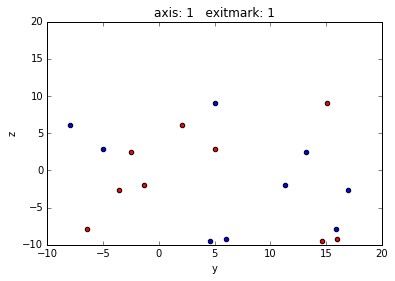

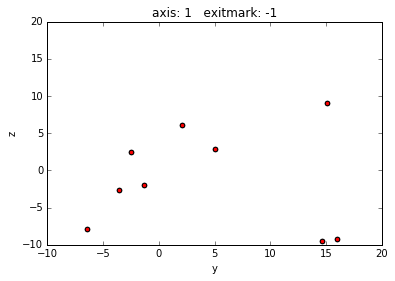

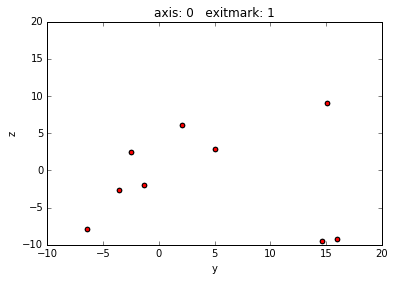

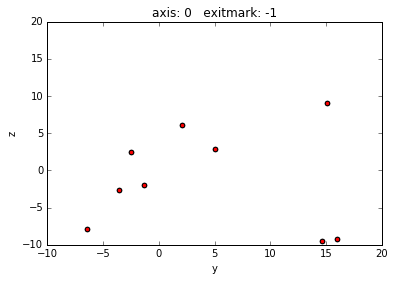

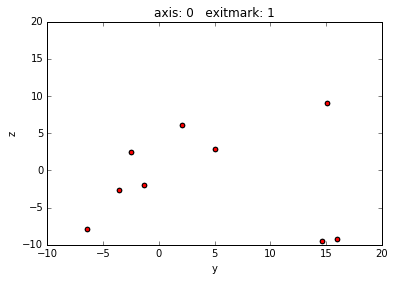

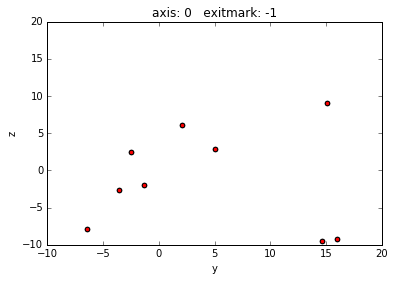

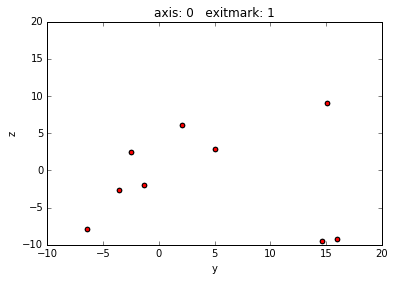

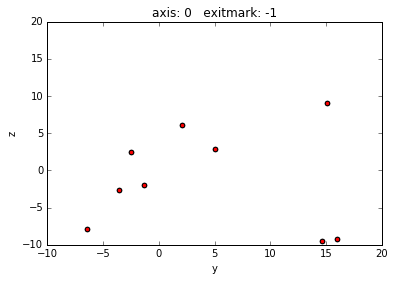

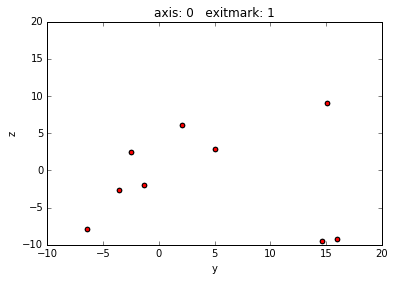

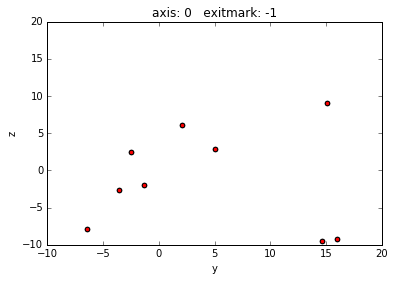

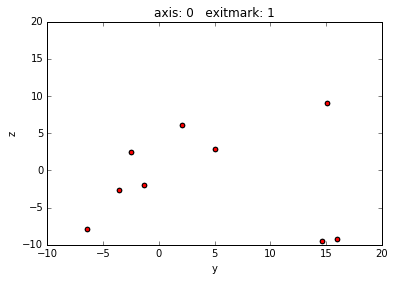

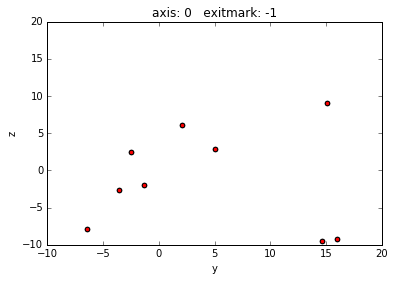

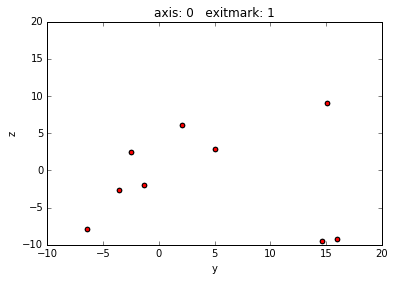

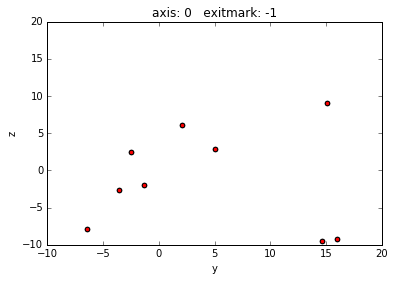

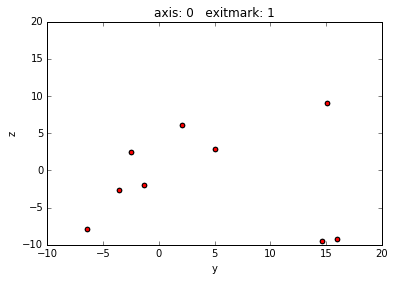

In [36]:
for i in range(60,75):
    ys = positions[i,:,1]
    zs = positions[i,:,2]
    plt.scatter(ys, zs)
    plt.scatter(positions[i+1,:,1], positions[i+1,:,2],c='r')
    plt.title('axis: '+str(axis[i])+'   exitmark: '+str(exitmark[i]))
    plt.xlabel('y')
    plt.ylabel('z')
    plt.xlim([-10,20])
    plt.ylim([-10,20])
    plt.show()

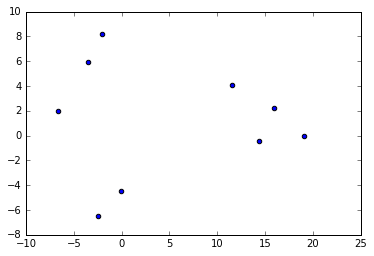

In [37]:
data = [[0,-3.47478,5.95625],[0,-2.00696,8.21978],[0,11.4951,4.11067],[0,14.3885,-0.456447],[0,-2.43914,-6.49816],[0,-6.69911,1.95724],[0,15.9702,2.22784],[0,19.0883,-0.0222026],[0,-0.0184129,-4.45041]]
data = np.array(data)
plt.scatter(data[:,1],data[:,2])

In [61]:
dataMoreRan = [
    [[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-0.833875,12.9025],[0,-6.73522,12.6424],[0,0.625328,14.2353]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,1.3502,10.7357],[0,-0.702474,14.5147],[0,-3.77078,12.4025],[0,-6.23867,19.3871],[0,0.71116,17.6119]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,12.7195,-5.7193],[0,1.35086,-3.93772],[0,5.18134,-3.81986]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,5.85031,12.276],[0,18.0489,12.9921],[0,16.1542,11.7154],[0,-9.8026,17.3382],[0,-7.47845,16.9403]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,17.0789,-5.72255],[0,-3.42368,-2.71693],[0,14.3468,-1.87695],[0,-3.55651,-5.08898]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-5.12678,16.7994],[0,4.66272,15.8985]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-9.29264,-5.01078],[0,-6.22915,-7.05887],[0,5.09122,-8.28036],[0,-0.382473,-5.79482],[0,-9.84026,-4.47026]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,12.5048,18.4957]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-4.78059,-1.17354],[0,-2.55441,-1.96206]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,1.61125,12.2773],[0,-2.28283,14.0311],[0,9.61954,12.3577]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,19.6538,-1.1555],[0,4.24622,-5.70739]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,8.20089,10.0746],[0,1.26174,11.6795],[0,11.9481,16.4708],[0,13.0402,10.265]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-5.3799,-8.135],[0,-9.52233,-4.79585],[0,-2.78691,-7.79535],[0,-2.63922,-3.69468],[0,12.0885,-6.40265]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-5.93865,11.3408],[0,7.57853,17.3994],[0,-8.69558,18.617]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,4.69669,-2.83988],[0,15.7082,-8.05681]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,19.162,11.2063],[0,18.8937,17.2805]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,18.3531,-8.57485],[0,19.8681,-8.4114],[0,14.9246,-9.94398],[0,17.2598,-7.99119]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-4.03204,13.6819],[0,-3.9507,19.9335],[0,1.34273,10.4686],[0,2.58248,16.413]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,13.0239,-0.696414],[0,-2.60812,-8.99336],[0,-4.67634,-2.17395],[0,10.2982,-2.00519],[0,19.9888,-6.37685],[0,-3.79755,-4.13481]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-1.53608,17.372],[0,9.26949,11.243],[0,5.8562,13.5806],[0,-9.74077,19.3317]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-7.65569,-4.8425],[0,10.1097,-2.45089]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,14.0538,11.1919],[0,1.80364,19.1517],[0,-3.51428,15.9478],[0,18.1966,11.1654],[0,14.2877,16.8681],[0,4.61291,17.036]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,10.1865,-5.36853],[0,-5.50257,-1.73531],[0,17.4876,-4.33709]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,11.0569,14.0357],[0,4.17405,15.9435],[0,0.895474,16.0928],[0,0.663764,16.0009]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,9.4231,-1.44878],[0,-3.20285,-8.04225],[0,-1.74683,-0.686116],[0,11.1103,-4.2465]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-6.61516,16.4415],[0,5.20512,13.5427],[0,-8.79445,14.5786],[0,13.1643,19.5108],[0,-9.55655,17.8774]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,15.3562,-8.77507],[0,-9.47473,-0.397704],[0,-2.62548,-7.18768]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,10.4734,19.2511],[0,11.3144,13.9586],[0,5.31048,16.8485]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,4.87263,-9.65066],[0,-0.0229091,-4.43521]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,1.99603,15.2463]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-6.24328,-5.13978],[0,11.6496,-0.865752],[0,-9.92423,-9.65169]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,15.1608,14.5958],[0,0.378629,12.3983]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,12.9494,-1.43609],[0,8.78003,-1.95256]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,2.88879,15.7362],[0,-9.92691,10.4327]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,18.625,-3.67315],[0,5.07748,-5.77665],[0,-9.99297,-3.77148]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-1.2019,-1.30168],[0,11.5341,-5.04316],[0,-5.01814,-6.83513]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-9.10703,10.6337]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,17.4826,12.1211]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,11.0833,-9.16389]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,6.19158,16.2252],[0,-5.66968,13.7873],[0,8.12355,18.8516]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-9.7593,-6.44831],[0,5.27197,-0.761917]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-6.87447,17.1875],[0,12.6931,12.0429]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,16.1253,-9.92325],[0,13.3661,-1.33307]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-8.18323,11.2951]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,4.43902,-7.66512],[0,-4.52811,-3.8745]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,9.94624,19.8578],[0,9.62253,14.6915],[0,1.23737,16.6293],[0,9.44653,12.6319]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-8.49117,-1.03299],[0,10.4952,-1.12689]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,5.54217,13.1667],[0,-5.8977,15.5428],[0,18.1004,13.2917],[0,11.5229,19.5093],[0,-4.77723,13.9423]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,3.58031,-9.62095],[0,16.857,-3.02737],[0,5.58315,-0.765597],[0,0.522401,-1.69684],[0,-1.91692,-9.05505]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,19.4435,16.9699],[0,8.33118,19.5996],[0,-4.82432,17.3932]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-3.68157,-8.03467],[0,8.25834,-4.55992],[0,13.1743,-2.08086]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,0.263941,18.0299],[0,2.21593,15.6],[0,-6.58563,17.6831]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,12.6094,-4.19872],[0,-3.1117,-8.16032],[0,2.20564,-5.79298]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,17.5207,12.3975],[0,6.29175,12.184],[0,-2.33101,15.923],[0,9.23176,10.5069],[0,9.55069,19.029]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,-7.74911,-4.45827]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,5.38028,17.0698],[0,15.4419,19.1186],[0,18.7966,19.5759],[0,-5.63199,15.1436],[0,8.82495,18.1333]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,2.8847,-7.40259],[0,-2.99607,-6.58507],[0,18.6167,-7.11781],[0,3.40871,-8.31133],[0,15.4802,-2.37036]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,-5.3182,19.59]],
[[2,-1] ,[0,10.3355,18.9658],[0,2.05898,0.771884],[0,2.4621,2.21453],[0,18.3463,7.799],[0,11.5232,14.6597],[0,17.7632,6.5389],[0,16.5134,7.75385],[0,5.29287,7.62309],[0,10.8578,13.7838],[0,3.42192,4.77555],[0,17.6791,8.35312],[0,11.2254,1.38838],[0,14.9589,5.89663],[0,19.1101,-9.29422],[0,-3.78988,-7.58317],[0,3.78814,-9.95952],[0,12.5679,-3.8318],[0,-9.95433,-3.65463]],
[[2,1] ,[0,10.3355,8.96575],[0,2.05898,-9.22812],[0,2.4621,-7.78547],[0,18.3463,-2.201],[0,11.5232,4.65965],[0,17.7632,-3.4611],[0,16.5134,-2.24615],[0,5.29287,-2.37691],[0,10.8578,3.78382],[0,3.42192,-5.22445],[0,17.6791,-1.64688],[0,11.2254,-8.61162],[0,14.9589,-4.10337],[0,5.53999,15.601],[0,-6.72395,13.1247],[0,1.27831,15.1816],[0,16.0265,12.6774],[0,8.9467,11.0477],[0,12.9579,16.2232]]
]

In [62]:
axis = [x[0][0] for x in dataMoreRan]
exitmark = [x[0][1] for x in dataMoreRan]
positions = ([x[1:] for x in dataMoreRan])
print(len(positions[0]))

16


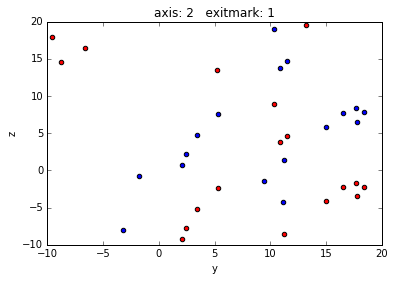

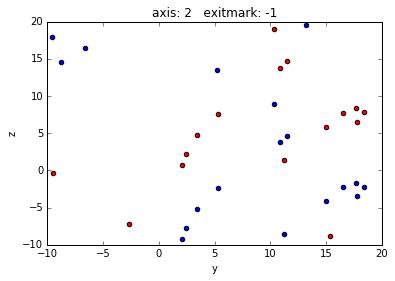

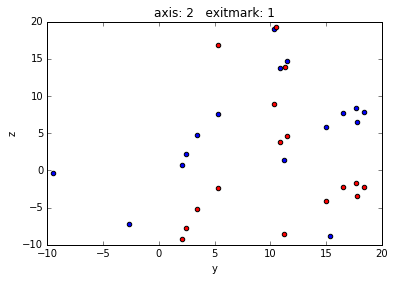

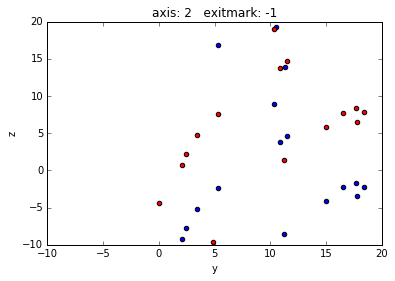

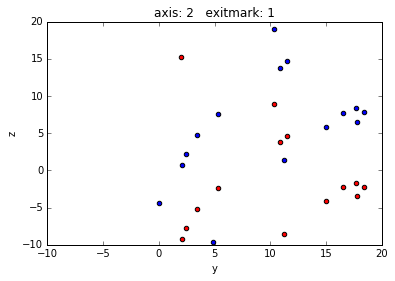

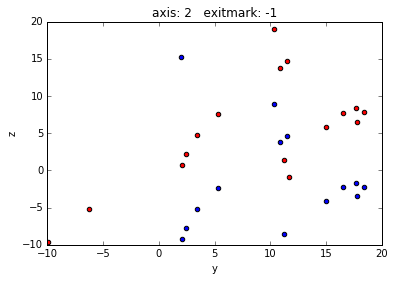

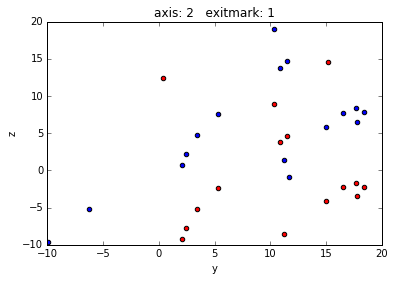

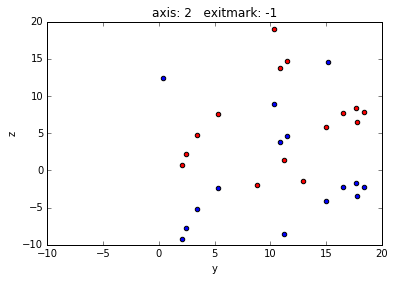

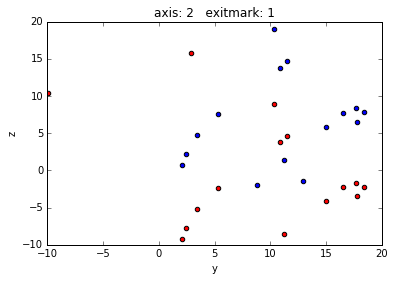

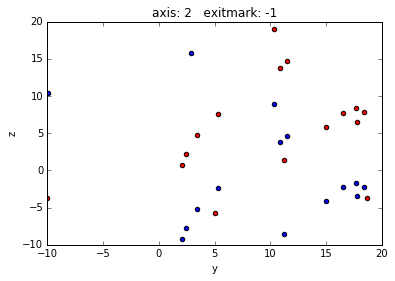

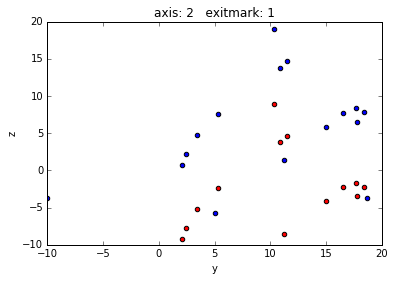

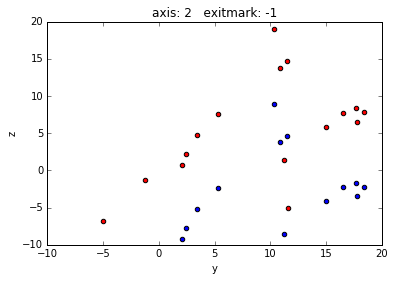

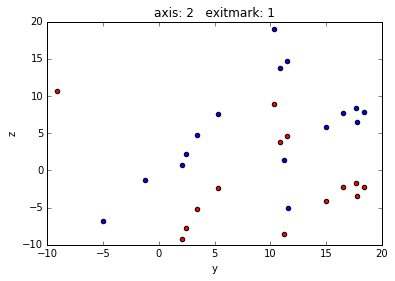

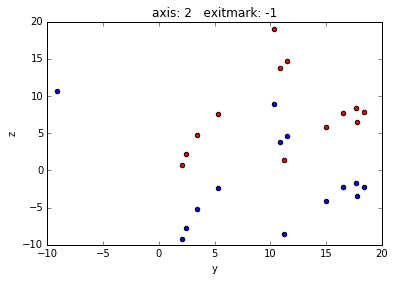

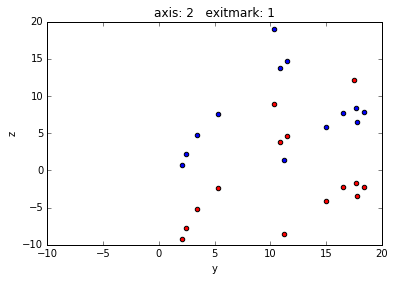

In [63]:
for i in range(25,40):
    ys = [x[1] for x in positions[i]]
    zs = [x[2] for x in positions[i]]
    ysn = [x[1] for x in positions[i+1]]
    zsn = [x[2] for x in positions[i+1]]
    plt.scatter(ys, zs)
    plt.scatter(ysn, zsn,c='r')
    plt.xlabel('y')
    plt.ylabel('z')
    plt.title('axis: '+str(axis[i-1])+'   exitmark: '+str(exitmark[i-1]))
    plt.xlim([-10,20])
    plt.ylim([-10,20])
    plt.show()